<a href="https://colab.research.google.com/github/NicoPozio/WildfireDetectionDL/blob/main/notebook/Classifier_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NicoPozio/WildfireDetectionDL.git

Cloning into 'WildfireDetectionDL'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 261 (delta 35), reused 2 (delta 0), pack-reused 188 (from 1)
Receiving objects: 100% (261/261), 185.40 KiB | 15.45 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [2]:
import sys

repo_path = '/content/WildfireDetectionDL'
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [3]:
# Cell: Update Code
import os

REPO_PATH = "/content/WildfireDetectionDL"

print("Syncing with GitHub...")
!cd {REPO_PATH} && git pull

print("Code updated. You can now run the Sweep or Train cell immediately.")

Syncing with GitHub...
Already up to date.
Code updated. You can now run the Sweep or Train cell immediately.


In [4]:
#Install Project Dependencies
#hydra-core: Configuration management
#wandb: Experiment tracking
#omegaconf: Dict handling for Hydra
!pip install -q hydra-core wandb omegaconf


from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Google Drive Mounted")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.5 MB/s eta 0:00:00
Mounted at /content/drive
Google Drive Mounted


In [5]:
import wandb
from google.colab import userdata
import os

try:
    #Fetch key from Colab Secrets
    api_key = userdata.get('WANDB_API_KEY')

    #Set as Environment Variable
    #This ensures Hydra and subprocesses can find it automatically
    os.environ["WANDB_API_KEY"] = api_key

    wandb.login()
    print("Logged in to WandB")

except Exception as e:
    print(f"Authentication Failed: {e}")
    print("Action Required: Go to the 'Secrets' tab (Key icon) on the left.")
    print("Add a new secret named 'WANDB_API_KEY' with your key from https://wandb.ai/authorize")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: pozioniccolo (pozioniccolo-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged in to WandB


First we download the dataset, we check if the user has the data in its google drive, if not it's downloaded from a public link

In [6]:
import os
import gdown
from src.utils import extract_zip

#Destination on Colab
local_root = "/content/data"
os.makedirs(local_root, exist_ok=True)
!rm -rf {local_root}/*

#Paths on drive (in case the CyclaGAN notebook is exectued)
drive_dataset_path = "/content/drive/MyDrive/Wildfire_Project/dataset.zip"
drive_synthetic_path = "/content/drive/MyDrive/Wildfire_Project/synthetic_wildfire_2k.zip"

#Paths on Colab
target_dataset_zip = os.path.join(local_root, "dataset.zip")
target_synthetic_zip = os.path.join(local_root, "synthetic_wildfire_2k.zip")



#Check if the file are present
if os.path.isfile(drive_dataset_path) and os.path.isfile(drive_synthetic_path):
    !cp "{drive_dataset_path}" "{target_dataset_zip}"
    !cp "{drive_synthetic_path}" "{target_synthetic_zip}"

else:

    DATASET_ID = "17KPBVodZkmBYqz7252mDk6hfY55eMU-Q"
    SYNTHETIC_ID = "1KyI09FDCAkLp1BYO-VgD7zRMrtrl3anK"

    gdown.download(id=DATASET_ID, output=target_dataset_zip, quiet=False)

    gdown.download(id=SYNTHETIC_ID, output=target_synthetic_zip, quiet=False)


if os.path.exists(target_dataset_zip) and os.path.exists(target_synthetic_zip):
    if os.path.getsize(target_dataset_zip) > 0:
        extract_zip(target_dataset_zip, local_root)
    if os.path.getsize(target_synthetic_zip) > 0:
        extract_zip(target_synthetic_zip, local_root)
    print("Data Ready")

Extracting dataset.zip to /content/data...


Unzipping: 100%|██████████| 42860/42860 [00:12<00:00, 3412.27files/s]


 -> Success: Extracted to /content/data
Extracting synthetic_wildfire_2k.zip to /content/data...


Unzipping: 100%|██████████| 2003/2003 [00:01<00:00, 1325.52files/s]

 -> Success: Extracted to /content/data
Data Ready


In [7]:
import os
from PIL import Image
from tqdm import tqdm

# Define your data root
DATA_ROOT = "/content/data"

print(f"Scanning {DATA_ROOT} for corrupt images...")

corrupt_count = 0
for root, dirs, files in os.walk(DATA_ROOT):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, filename)
            try:
                # Try to fully load the image bytes
                with Image.open(file_path) as img:
                    img.load()
            except OSError:
                print(f"Found corrupt image: {file_path}")
                try:
                    os.remove(file_path)
                    print(f"Deleted {filename}")
                    corrupt_count += 1
                except:
                    print(f"Could not delete {filename}")

print(f"\nScan Complete. Removed {corrupt_count} corrupt files.")

Scanning /content/data for corrupt images...
Found corrupt image: /content/data/dataset/test/wildfire/-73.15884,46.38819.jpg
Deleted -73.15884,46.38819.jpg
Found corrupt image: /content/data/dataset/train/nowildfire/-114.152378,51.027198.jpg
Deleted -114.152378,51.027198.jpg

Scan Complete. Removed 2 corrupt files.


In [ ]:
import subprocess
import os

# 1. Define Paths Constants
REPO_ROOT = "/content/WildfireDetectionDL"
SWEEP_CONFIG_PATH = os.path.join(REPO_ROOT, "conf", "sweep.yaml")

# 2. Validation
if not os.path.exists(SWEEP_CONFIG_PATH):
    print(f"CRITICAL ERROR: Could not find sweep.yaml at {SWEEP_CONFIG_PATH}")
else:
    print(f"Registering Sweep from {SWEEP_CONFIG_PATH}")

    # 3. Register the sweep
    result = subprocess.run(
        ["wandb", "sweep", SWEEP_CONFIG_PATH],
        capture_output=True,
        text=True,
        # CORRECTION: cwd must be the directory, not the file
        cwd=REPO_ROOT
    )

    output_text = result.stderr + result.stdout
    print("Raw Output:", output_text)

    # 4. Extract Sweep ID
    sweep_id = None
    for line in output_text.split('\n'):
        if "wandb agent" in line:
            parts = line.strip().split("wandb agent ")
            if len(parts) > 1:
                sweep_id = parts[-1].strip()
                break

    # 5. Launch the Agent
    if sweep_id:
        print(f"\nSUCCESS: Detected Sweep ID: {sweep_id}")
        print("Starting Agent... (This will run multiple experiments)")

        # CORRECTION: We use the explicit REPO_ROOT variable defined at the top
        !cd {REPO_ROOT} && wandb agent {sweep_id} --count 20
    else:
        print("\nERROR: Could not find Sweep ID.")

Registering Sweep from /content/WildfireDetectionDL/conf/sweep.yaml


KeyboardInterrupt: 

With the sweep execution we found the best configuration for the neural networks, now we train the resnet50 using that parameters, we train using both synthetic+real, and only real

In [8]:
import subprocess
import sys
import os

# ---------------------------------------------------------
# Hyperparameter Configurations
# ---------------------------------------------------------

# 1. ResNet50
RESNET_CONFIG = [
    "model.name=resnet50",
    "model.dropout=0.5",
    "dataset.augmentation.rotation_degrees=11",
    "training.batch_size=64",
    "training.learning_rate=0.00005836874490583941",
    "training.optimizer=adam",
    "training.weight_decay=0.00000621085260935666",
    "training.epochs=20",
    "dataset.params.real_data_fraction=0.5"
]

# 2. SimpleCNN
SIMPLE_CNN_CONFIG = [
    "model.name=simple_cnn",
    "model.dropout=0.5",
    "dataset.augmentation.rotation_degrees=4",
    "training.batch_size=64",
    "training.learning_rate=0.00001349",
    "training.optimizer=adam",
    "training.weight_decay=0.00000823",
    "training.epochs=20",
    "dataset.params.real_data_fraction=0.5"
]

# 3. EfficientNet
EFFICIENTNET_CONFIG = [
    "model.name=efficientnet",
    "model.dropout=0.2",
    "dataset.augmentation.rotation_degrees=15",
    "training.batch_size=32",
    "training.learning_rate=0.0001",
    "training.optimizer=adam",
    "training.weight_decay=0.0",
    "training.epochs=20",
    "dataset.params.real_data_fraction=0.5"
]

# Pipeline Logic

def run_training_pipeline(model_label, use_synthetic, config_list):
    run_id = f"{model_label}_{'Synthetic' if use_synthetic else 'RealOnly'}"
    print(f"\n{'='*60}")
    print(f"STARTING TRAINING PIPELINE: {run_id}")
    print(f"{'='*60}")

    train_cmd = [
        sys.executable, "train.py",
        f"dataset.params.use_synthetic={str(use_synthetic).lower()}",
        "wandb.project=wildfire-final-benchmark",
        f"+wandb.name={run_id}"
    ] + config_list

    try:
        process = subprocess.Popen(
            train_cmd,
            cwd="/content/WildfireDetectionDL",
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )

        for line in process.stdout:
            print(line, end="")

        process.wait()

        if process.returncode != 0:
            print(f"\nTRAINING FAILED: {run_id}")
            return False
        else:
            print("\nTraining Complete.")
            return True

    except Exception as e:
        print(f"CRITICAL ERROR: {e}")
        return False

# Execution Loop
# ResNet50
run_training_pipeline("ResNet50", False, RESNET_CONFIG)
run_training_pipeline("ResNet50", True, RESNET_CONFIG)

# SimpleCNN
run_training_pipeline("SimpleCNN", False, SIMPLE_CNN_CONFIG)
run_training_pipeline("SimpleCNN", True, SIMPLE_CNN_CONFIG)

# EfficientNet
run_training_pipeline("EfficientNet", False, EFFICIENTNET_CONFIG)
run_training_pipeline("EfficientNet", True, EFFICIENTNET_CONFIG)


STARTING TRAINING PIPELINE: ResNet50_RealOnly
wandb: Currently logged in as: pozioniccolo (pozioniccolo-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: setting up run rj51yp2w
wandb: Tracking run with wandb version 0.23.0
wandb: Run data is saved locally in /content/WildfireDetectionDL/wandb/run-20251202_221223-rj51yp2w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run serene-yogurt-7
wandb: ⭐️ View project at https://wandb.ai/pozioniccolo-sapienza-universit-di-roma/wildfire-final-benchmark
wandb: 🚀 View run at https://wandb.ai/pozioniccolo-sapienza-universit-di-roma/wildfire-final-benchmark/runs/rj51yp2w
Training on cuda using model: resnet50
SCARCITY MODE ENABLED: Using 10.0% of Real Data.
   Original Size: 30249 -> Reduced Size: 3024
Real Data Ready. Size: 3024
BASELINE MODE: Using only Real data.
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/re

True

Found 6 models to test.

ANALYZING FOLDER: efficientnet_340ug7is
   Model: efficientnet
   Synthetic Data: False
   Weights loaded successfully.
   Running Inference...
   Testing Success.
      Accuracy:  0.4664
      Precision: 0.5303
      Recall:    0.2963
      F1-Score:  0.3802
   Displaying Confusion Matrix for efficientnet_340ug7is:


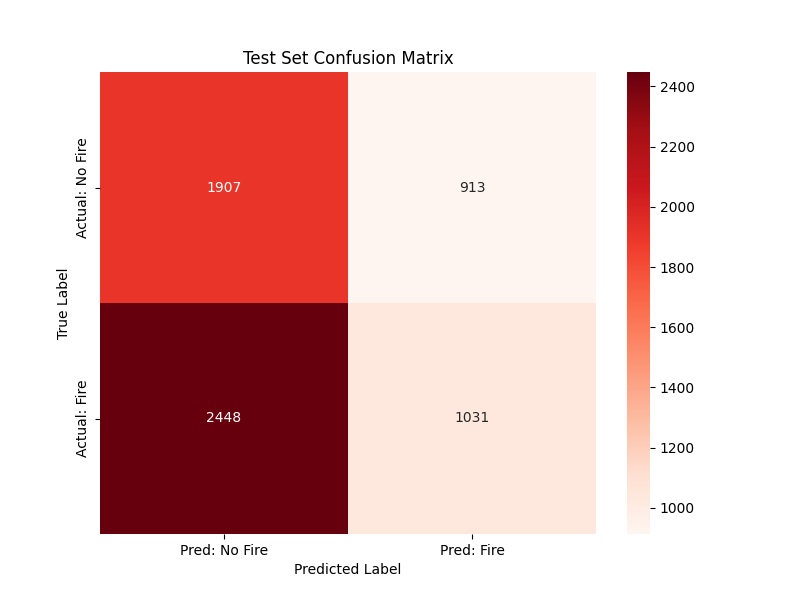


ANALYZING FOLDER: efficientnet_fvi5i0kv
   Model: efficientnet
   Synthetic Data: True
   Weights loaded successfully.
   Running Inference...
   Testing Success.
      Accuracy:  0.4666
      Precision: 0.5306
      Recall:    0.2966
      F1-Score:  0.3805
   Displaying Confusion Matrix for efficientnet_fvi5i0kv:


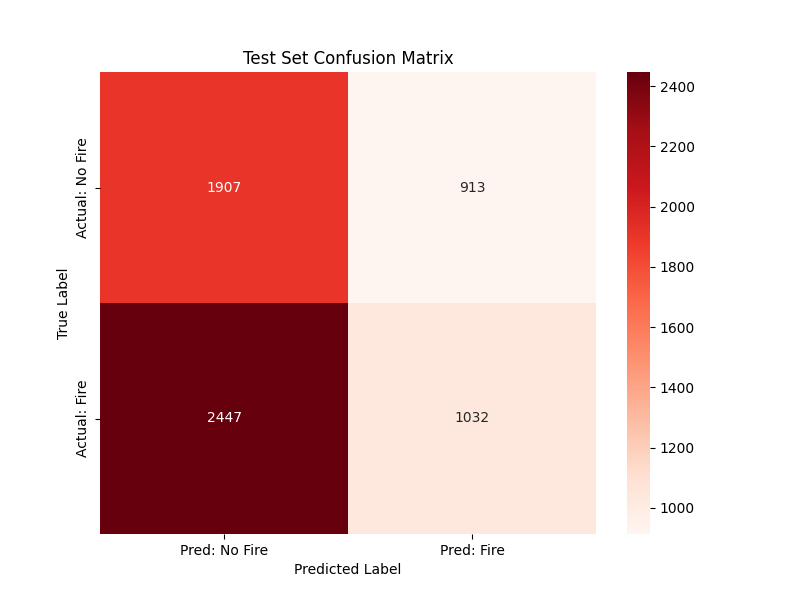


ANALYZING FOLDER: resnet50_d2u0eaea
   Model: resnet50
   Synthetic Data: True
   Weights loaded successfully.
   Running Inference...
   Testing Failed.
Error executing job with overrides: ['model.name=resnet50', 'model.dropout=0.5', 'dataset.params.use_synthetic=true', 'training.batch_size=32', 'wandb.mode=disabled', '+model_path=best_model.pth']
Traceback (most recent call last):
    raise RuntimeError("Architecture Mismatch: File contains SimpleCNN weights, but Model is ResNet.")
RuntimeError: Architecture Mismatch: File contains SimpleCNN weights, but Model is ResNet.

ANALYZING FOLDER: resnet50_rj51yp2w
   Model: resnet50
   Synthetic Data: False
   Weights loaded successfully.
   Running Inference...
   Testing Failed.
Error executing job with overrides: ['model.name=resnet50', 'model.dropout=0.5', 'dataset.params.use_synthetic=false', 'training.batch_size=32', 'wandb.mode=disabled', '+model_path=best_model.pth']
Traceback (most recent call last):
    raise RuntimeError("Archit

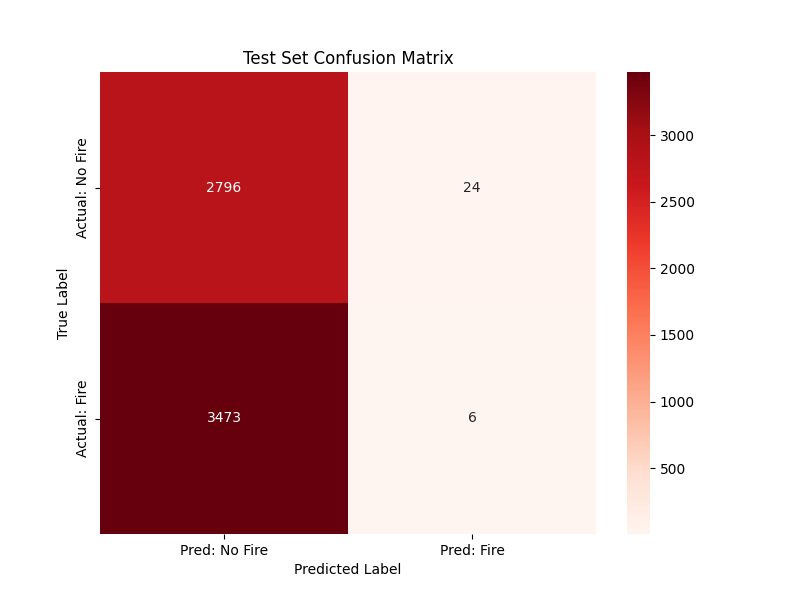


ANALYZING FOLDER: simple_cnn_q7uzpnf0
   Model: simple_cnn
   Synthetic Data: True
   Weights loaded successfully.
   Running Inference...
   Testing Success.
      Accuracy:  0.4448
      Precision: 0.2000
      Recall:    0.0017
      F1-Score:  0.0034
   Displaying Confusion Matrix for simple_cnn_q7uzpnf0:


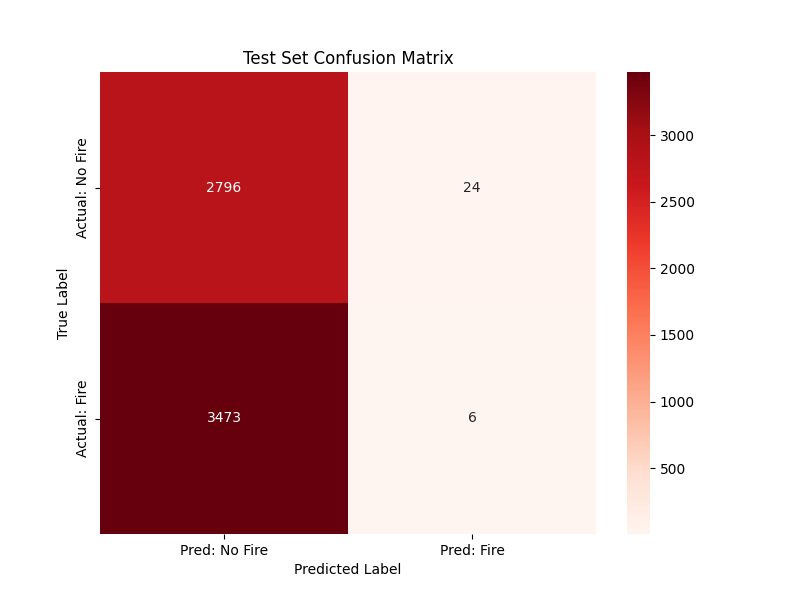

In [10]:
import os
import subprocess
import shutil
from omegaconf import OmegaConf
from google.colab import drive
from IPython.display import display, Image

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DRIVE_SAVE_ROOT = "/content/drive/MyDrive/Wildfire_Project/saved_models"
WORK_DIR = "/content/WildfireDetectionDL"

def run_test_from_drive_folder(folder_path):
    folder_name = os.path.basename(folder_path)
    print(f"\n{'='*60}")
    print(f"ANALYZING FOLDER: {folder_name}")
    print(f"{'='*60}")

    config_path = os.path.join(folder_path, "config.yaml")
    weights_path = os.path.join(folder_path, "best_weights.pth")

    if not os.path.exists(config_path) or not os.path.exists(weights_path):
        print(f"Skipping {folder_name}: Missing config.yaml or best_weights.pth")
        return

    try:
        cfg = OmegaConf.load(config_path)
        model_name = cfg.model.name
        dropout = cfg.model.dropout
        use_synthetic = False
        if "dataset" in cfg and "params" in cfg.dataset:
            use_synthetic = cfg.dataset.params.get("use_synthetic", False)

        print(f"   Model: {model_name}")
        print(f"   Synthetic Data: {use_synthetic}")

    except Exception as e:
        print(f"Error reading config: {e}")
        return

    if os.path.exists("best_model.pth"):
        os.remove("best_model.pth")

    try:
        shutil.copy(weights_path, "best_model.pth")
        print("   Weights loaded successfully.")
    except Exception as e:
        print(f"   Failed to copy weights: {e}")
        return

    cmd = [
        "python", "test.py",
        f"model.name={model_name}",
        f"model.dropout={dropout}",
        f"dataset.params.use_synthetic={str(use_synthetic).lower()}",
        "training.batch_size=32",
        "wandb.mode=disabled",
        "+model_path=best_model.pth"
    ]

    print("   Running Inference...")
    proc = subprocess.run(
        cmd,
        cwd=WORK_DIR,
        capture_output=True,
        text=True
    )

    if proc.returncode == 0:
        print("   Testing Success.")
        for line in proc.stdout.split('\n'):
            if any(k in line for k in ["Accuracy:", "Precision:", "Recall:", "F1-Score:"]):
                print(f"      {line.strip()}")

        # Display Confusion Matrix
        img_path = os.path.join(WORK_DIR, "confusion_matrix.png")
        if os.path.exists(img_path):
            print(f"   Displaying Confusion Matrix for {folder_name}:")
            display(Image(filename=img_path))
        else:
            print("   Warning: confusion_matrix.png not generated.")

    else:
        print("   Testing Failed.")
        lines = proc.stderr.split('\n')
        for line in lines:
            if "Error" in line or "Traceback" in line:
                print(line)

    if os.path.exists("best_model.pth"):
        os.remove("best_model.pth")

if os.path.exists(DRIVE_SAVE_ROOT):
    folders = [f.path for f in os.scandir(DRIVE_SAVE_ROOT) if f.is_dir()]

    if not folders:
        print("No model folders found in Drive.")
    else:
        print(f"Found {len(folders)} models to test.")
        for folder in sorted(folders):
            run_test_from_drive_folder(folder)
else:
    print(f"Critical Error: Folder {DRIVE_SAVE_ROOT} does not exist.")